# ライブラリのインポートと基本設定

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ハイパーパラメータの設定
img_rows = 28
img_cols = 28
channels = 1
img_shape = (channels, img_rows, img_cols) # PyTorchは (C, H, W) 形式
z_dim = 100 # Latent Space（潜在空間）の次元数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator（生成器）の定義

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            # Fully Connected Layer（全結合層）
            nn.Linear(z_dim, 128),
            # Leaky ReLU Activation
            nn.LeakyReLU(0.01, inplace=True),
            # Output Layer
            nn.Linear(128, int(np.prod(img_shape))),
            # Tanh Activation（出力を[-1, 1]の範囲に収める）
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        # 1次元の出力を画像サイズ (Channels, Height, Width) に変形
        img = img.view(img.size(0), *self.img_shape)
        return img

# Discriminator（識別器）の定義

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Flatten（画像を1次元ベクトルに変換）
            nn.Flatten(),
            # Fully Connected Layer
            nn.Linear(int(np.prod(img_shape)), 128),
            # Leaky ReLU Activation
            nn.LeakyReLU(0.01, inplace=True),
            # Output Layer
            nn.Linear(128, 1),
            # Sigmoid Activation（[0, 1]の確率値として出力）
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# モデルの構築と最適化アルゴリズムの設定

In [4]:
# インスタンス化
generator = Generator(z_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# 損失関数: Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer（最適化アルゴリズム）: Adam
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 学習ループ

1 [D loss: 0.6896] [G loss: 0.6773]


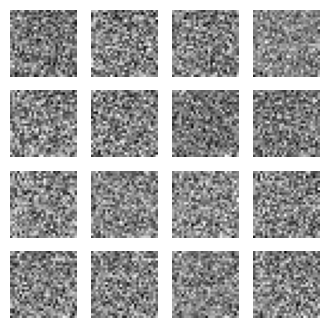

1001 [D loss: 0.4225] [G loss: 0.9285]


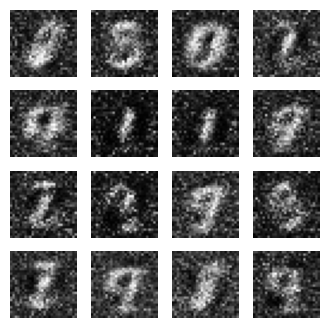

2001 [D loss: 0.3615] [G loss: 2.0029]


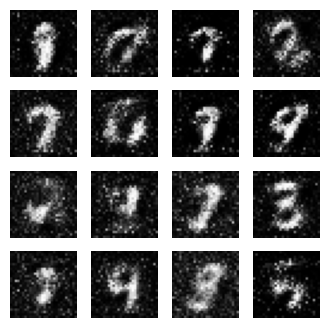

3001 [D loss: 0.3235] [G loss: 1.5745]


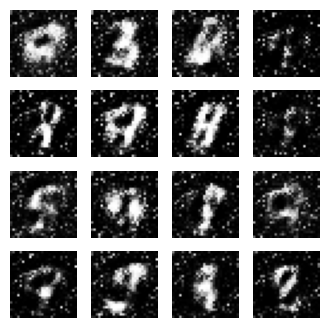

4001 [D loss: 0.4179] [G loss: 1.3507]


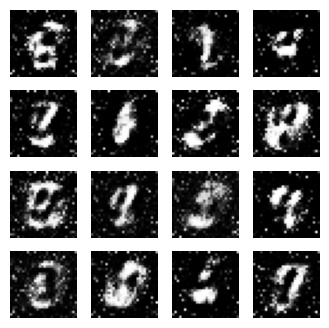

5001 [D loss: 0.4880] [G loss: 1.4837]


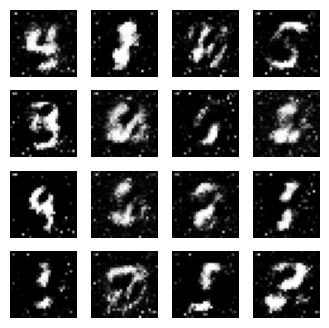

6001 [D loss: 0.3574] [G loss: 1.5635]


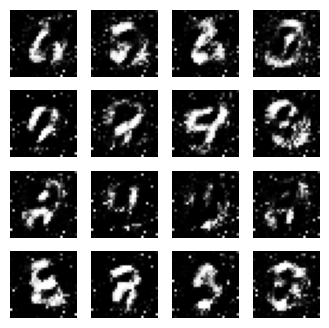

In [ ]:
def train(iterations, batch_size, sample_interval):
    # MNISTデータの読み込みと前処理 ([-1, 1]に正規化)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataloader = DataLoader(
        datasets.MNIST('.', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True
    )

    losses = []
    iteration_checkpoints = []

    # イテレータの作成
    data_iter = iter(dataloader)

    for iteration in range(iterations+1):
        
        # --- データの準備 ---
        try:
            real_imgs, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            real_imgs, _ = next(data_iter)

        real_imgs = real_imgs.to(device)
        # 教師ラベル: 本物は1, 偽物は0
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        #  Train Discriminator
        # -------------------------
        optimizer_D.zero_grad()

        # 本物の画像の判定
        d_loss_real = criterion(discriminator(real_imgs), valid)
        
        # 偽物の画像の生成と判定
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z)
        d_loss_fake = criterion(discriminator(gen_imgs.detach()), fake)

        # 誤差逆伝播と更新
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # 偽物を「本物(1)」と判定させることが目標
        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Progress Logging
        # ---------------------
        if iteration % sample_interval == 0:
            print(f"{iteration} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            losses.append((d_loss.item(), g_loss.item()))
            iteration_checkpoints.append(iteration + 1)
            sample_images(generator)
            
    return np.array(losses), iteration_checkpoints

def sample_images(generator, rows=4, cols=4):
    generator.eval()
    z = torch.randn(rows * cols, z_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = 0.5 * gen_imgs + 0.5 # [-1, 1] -> [0, 1]

    fig, axs = plt.subplots(rows, cols, figsize=(4, 4))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# 実行
losses, checkpoints = train(iterations=10000, batch_size=128, sample_interval=1000)